In [40]:
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# featurizer class definition

class Featurizer():
    
    def __init__(self, fp_len, fp_type):
        self.fp_len = fp_len
        self.fp_type = fp_type
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        
        df = df[df['Ki']<=1e4]
        df = df[df['Ki']>0.01]
        labels = df['Ki']
        
        fp = []
        for index, row in df.iterrows():
            fp = row[1:self.fp_len+1]
            fingerprints.append(fp)
            
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels
        
class KlekFeaturizer(Featurizer):
    def __init__(self, fp_len=4860, fp_type='Klek',):
        super().__init__(fp_len, fp_type)
    
class MACCSFeaturizer(Featurizer):
    def __init__(self, fp_len=166, fp_type='MACCS'):
        super().__init__(fp_len, fp_type)
        
class SubFeaturizer(Featurizer):
    def __init__(self, fp_len=307, fp_type='Sub'):
        super().__init__(fp_len, fp_type)

In [41]:
#file to DataFrame object

filename = 'data/d2_SubFP_final_file.csv'
df = pd.read_csv(filename)
df = df.dropna()

featurizer = SubFeaturizer()
X_train, y_train = featurizer(df)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

assert X_train.shape[0] == y_train.shape[0], 'X_train and y_train rows do not match'

In [42]:
from torch.utils.data import DataLoader, TensorDataset

tensor_ds = TensorDataset(X_train, y_train)
train = tensor_ds

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)

In [28]:
fp_len = featurizer.fp_len # Klek=4860, MACCS=166, Sub=307
code_len = 8 # 1 to 15

class Autoencoder(nn.Module):
    
    torch.set_default_dtype(torch.float64)
    
    def __init__(self, fp_len, code_len):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(fp_len, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, code_len)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(code_len ,16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, fp_len),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [43]:
def train(train_dataloader):

    epochs = 30
    
    model = Autoencoder(fp_len, code_len)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for epoch in range(epochs):
        for (fp, _) in train_dataloader:
            encoded, recon = model(fp)
            loss = criterion(recon, fp)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')
    
    return model
    
# train

model = train(train_dataloader)

Epoch: 1, Loss: 0.6890287583201512
Epoch: 2, Loss: 0.68272393999902
Epoch: 3, Loss: 0.6748098254450818
Epoch: 4, Loss: 0.6637656963751528
Epoch: 5, Loss: 0.6474948599285385
Epoch: 6, Loss: 0.6220967415618112
Epoch: 7, Loss: 0.5794100274327515
Epoch: 8, Loss: 0.5060113057819978
Epoch: 9, Loss: 0.39580200045287695
Epoch: 10, Loss: 0.2941363337010541
Epoch: 11, Loss: 0.1997128252919909
Epoch: 12, Loss: 0.1495323199393873
Epoch: 13, Loss: 0.10759161095927233
Epoch: 14, Loss: 0.09301773700688748
Epoch: 15, Loss: 0.08555202839789695
Epoch: 16, Loss: 0.06962744510581428
Epoch: 17, Loss: 0.07447917004934866
Epoch: 18, Loss: 0.06398976302718065
Epoch: 19, Loss: 0.06646787230249185
Epoch: 20, Loss: 0.057943204483147236
Epoch: 21, Loss: 0.05397386220825176
Epoch: 22, Loss: 0.0633279586627479
Epoch: 23, Loss: 0.05533060025311335
Epoch: 24, Loss: 0.07453751909219708
Epoch: 25, Loss: 0.06658279358465156
Epoch: 26, Loss: 0.06081649850256955
Epoch: 27, Loss: 0.06061229084371995
Epoch: 28, Loss: 0.0677

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10325 samples in 0.012s...
[t-SNE] Computed neighbors for 10325 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10325
[t-SNE] Computed conditional probabilities for sample 2000 / 10325
[t-SNE] Computed conditional probabilities for sample 3000 / 10325
[t-SNE] Computed conditional probabilities for sample 4000 / 10325
[t-SNE] Computed conditional probabilities for sample 5000 / 10325
[t-SNE] Computed conditional probabilities for sample 6000 / 10325
[t-SNE] Computed conditional probabilities for sample 7000 / 10325
[t-SNE] Computed conditional probabilities for sample 8000 / 10325
[t-SNE] Computed conditional probabilities for sample 9000 / 10325
[t-SNE] Computed conditional probabilities for sample 10000 / 10325
[t-SNE] Computed conditional probabilities for sample 10325 / 10325
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.169s
[t-SNE] Iteration 50: error = 105.48

<Axes: >

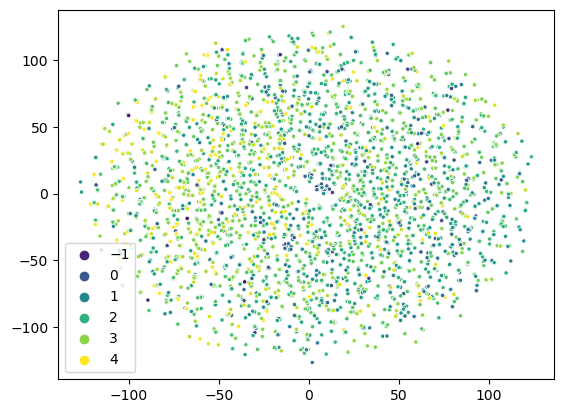

In [47]:
# encode

encoded, recon = model(X_train)

from sklearn.manifold import TSNE
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

encoded = encoded.detach().numpy()
encoded = np.transpose(encoded)

encoded_df = pd.DataFrame()
for i in range(8):
    encoded_df[f'{i+1}'] = encoded[i]
    
log10_Ki = np.log10(y_train)
X_tsne = TSNE(perplexity=5, verbose=3, learning_rate=100).fit_transform(encoded_df)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], marker=".", hue=(log10_Ki), palette='viridis')